In [0]:
import pandas as pd
import numpy as np
import keras
import zipfile as zf
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns

In [0]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [4]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [10]:
%cd /gdrive/'My Drive'

/gdrive/My Drive


# Processing data **file**

In [0]:
file = zf.ZipFile('plant-seedlings-classification.zip')

In [0]:
file.extractall()

In [0]:
file = zf.ZipFile('train.zip')
file.extractall()

In [0]:
TRAIN_DATA_FOLDER = 'train'

# Creating Images and class data set

In [0]:
images = []
classes =[]
missing=0
for class_folder_name in os.listdir(TRAIN_DATA_FOLDER):
    class_folder_path = os.path.join(TRAIN_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [0]:
def resize_images(img):
  img = np.array(img).astype(np.uint8)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

# Resize image & see distribution per class

In [0]:
images = [resize_images(img) for img in images]

In [37]:
#see number of images in each lablel
images = np.array(images)
classes = np.array(classes)
for label in set(classes):
  print("number of {} images are :  {}".format(label, len(images[classes == label])))

images shape:  (4750, 256, 256, 3)
classes shape:  (4750,)
number of Charlock images are :  390
number of Common Chickweed images are :  611
number of Black-grass images are :  263
number of Common wheat images are :  221
number of Loose Silky-bent images are :  654
number of Scentless Mayweed images are :  516
number of Fat Hen images are :  475
number of Shepherds Purse images are :  231
number of Maize images are :  221
number of Small-flowered Cranesbill images are :  496
number of Sugar beet images are :  385
number of Cleavers images are :  287


Text(0.5, 0.98, 'Categorical Plotting')

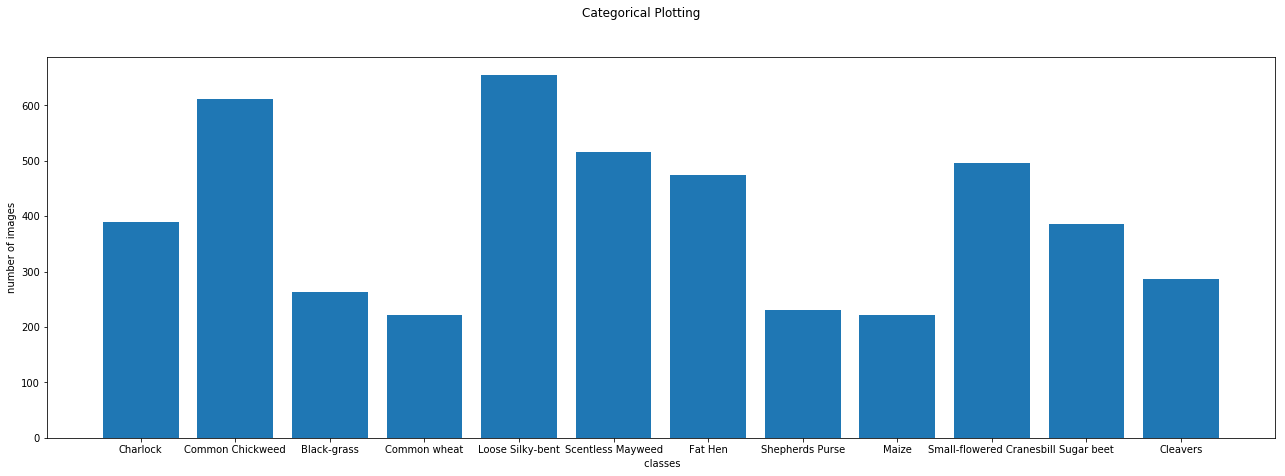

In [39]:
#plot the distrbution of number of images
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values)
ax.set_xlabel(" classes")
ax.set_ylabel("number of images")
#axs[1].scatter(label, )
  #axs[2].plot(names, values)
fig.suptitle('Categorical Plotting')

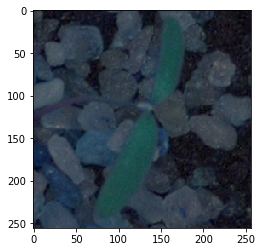

In [40]:

plt.imshow(images[35])

# Pre processing of image

In [0]:
#Image pre processings functions
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp
  
def segment(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

In [0]:
for indx, image in enumerate(images):
    images[indx] = segment(image)

# Model 

In [46]:
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(classes)
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=7)

In [0]:
X_test, X_val, y_test, Y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=7)

In [68]:

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', batch_input_shape = (5,256, 256, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.2))


model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (3,3),activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Dropout(0.4))

model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation = "relu"))

model.add(Dropout(0.5))

model.add(Dense(12, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (5, 252, 252, 32)         2432      
_________________________________________________________________
conv2d_26 (Conv2D)           (5, 248, 248, 32)         25632     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (5, 124, 124, 32)         0         
_________________________________________________________________
dropout_17 (Dropout)         (5, 124, 124, 32)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (5, 122, 122, 64)         18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (5, 122, 122, 64)         36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (5, 61, 61, 64)           0         
__________

In [0]:
model.compile(optimizer = 'Adam', loss = "categorical_crossentropy", metrics = ["accuracy"])

In [70]:
model.fit(X_train, y_train, epochs = 10, validation_data = (X_val,Y_val),batch_size = 5)

Train on 3325 samples, validate on 713 samples
Epoch 1/10
3325/3325 [==============================] - 29s 9ms/step - loss: 14.6068 - acc: 0.0929 - val_loss: 14.5809 - val_acc: 0.0954
Epoch 2/10
3325/3325 [==============================] - 28s 8ms/step - loss: 14.7921 - acc: 0.0815 - val_loss: 14.5809 - val_acc: 0.0954
Epoch 3/10
3325/3325 [==============================] - 28s 8ms/step - loss: 14.7532 - acc: 0.0839 - val_loss: 14.5809 - val_acc: 0.0954
Epoch 4/10
3325/3325 [==============================] - 28s 8ms/step - loss: 14.4953 - acc: 0.0998 - val_loss: 13.9479 - val_acc: 0.1346
Epoch 5/10
3325/3325 [==============================] - 28s 8ms/step - loss: 14.0744 - acc: 0.1260 - val_loss: 13.9479 - val_acc: 0.1346
Epoch 6/10
3325/3325 [==============================] - 28s 8ms/step - loss: 14.0936 - acc: 0.1251 - val_loss: 13.9479 - val_acc: 0.1346
Epoch 7/10
3325/3325 [==============================] - 28s 8ms/step - loss: 14.1466 - acc: 0.1215 - val_loss: 13.9479 - val_acc: 0

In [0]:
Y_pred = model.predict(X_val)


In [0]:
predicted_classes = model.predict_classes(X_test)